Dentro de vs_release_16k.zip descomprimimos dos carpetas:  
- audio_16k  
- meta  

Nos servimos del módulo zipfile para descomprimir y adicionalmente del módulo concurrent para utilizar threads agilizando la descompresión.  
https://superfastpython.com/multithreaded-unzip-files/#Unzip_Files_Concurrently_with_Processes

In [2]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

def unzip_file(handle, filename, path):
    handle.extract(path=path, member=filename)

output_dir = "data"
zip_file_name = "vs_release_16k.zip"
directories_to_extract = ["audio_16k", "meta"]

if not os.path.exists(output_dir):
    try:
        with ZipFile(zip_file_name, 'r') as zf:
            filenames = zf.namelist()

            files_to_extract = [
                file for file in filenames
                if any(file.startswith(dir) for dir in directories_to_extract)
            ]

            with ThreadPoolExecutor() as exe:
                for file in files_to_extract:
                    exe.submit(unzip_file, zf, file, output_dir)
    except:
        raise FileNotFoundError

print(os.listdir(output_dir))

['audio_16k', 'meta']


Ahora pasamos los datos a numpy arrays para poder trabajar con ellos:
Para ello vamos a usar multiprocessing, utilizamos una pool de cores para leer nuestros archivos.

In [3]:
import os
import wave
import numpy as np
import threading

def read_wav_file(wav_file):
    with wave.open(wav_file, 'rb') as wf:
        num_frames = wf.getnframes()
        frames = wf.readframes(num_frames)
        wave_array = np.frombuffer(frames, dtype=np.int16)
        wave_name = os.path.basename(wav_file)
        wave_name = os.path.splitext(wave_name)[0]
        # print(f"{wave_name} loaded ...")
    return wave_name, wave_array

def run_threads(task, data):
    threads = []
    results = []
    for d in data:
        thread = threading.Thread(target=task, args=(d, results))
        threads.append(thread)
        thread.start()
    for thread in threads:
        thread.join()
    return results

def process_file(wav_file, results):
    result = read_wav_file(wav_file)
    results.append(result)

base_dir = "data"
dir = "audio_16k"

audio_dir = os.path.join(base_dir, dir)
audios = os.listdir(audio_dir)
audio_paths = [os.path.join(audio_dir, file) for file in audios]
results = run_threads(task=process_file, data=audio_paths)
print(results[0])


('f0003_0_cough', array([38, 53, 50, ..., 19, 16,  9], dtype=int16))


f0003_0_cough.wav  
f -> female (o -> old? check transcripted) 
cough -> one of the 6 labels
0 -> index of that cough (individuals may have more than 1 cough registered)

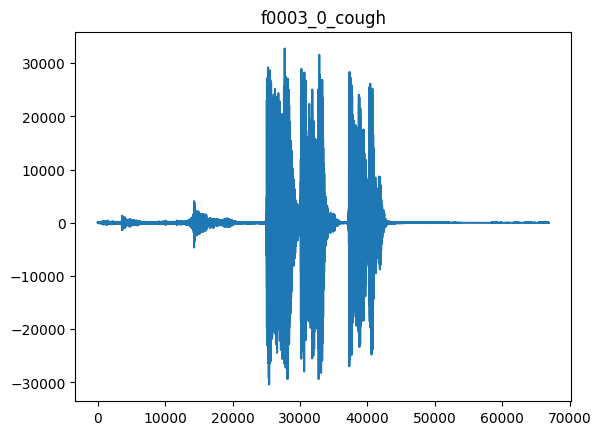

In [4]:
import matplotlib.pyplot as plt
name, arr = results[0]
plt.plot(arr)
plt.title(name)
plt.show()